## Visualizing single cell examples for pooled data
- Inputs are:
  - REQUIRED:
    -  **Input_gene_or_guide** - (str), it can be a string of gene symbol or guide (20 chars)
        - e.g., 'KRT28' or 'GTTGAAGAGCTAGATCAACG'
    -  **batch_name** - (str) batch name
        - e.g., '20200805_A549_WG_Screen' 
    - **rootDir** - image, metadata and overlays address is following the structure of dirs in the s3 bucket so we need to fix the root directory and everything else is being formed accroding to the s3 bucket structure 
        - e.g., '/home/ubuntu/calbucket/projects/2018_11_20_Periscope_Calico/'
  - OPTIONAL:
    -  **n_cells** - (int), number of single cells to be visualized, it is ignored if cell_selection_method is geometric_median
    -  **box_size** - (int), size of box in pixels for cropping a cell    
    -  **channels** - (list), list of channels you want to plot
        - e.g., ['DNA','Mito','Phalloidin','WGA','ER','Outline'] 
    -  **cell_selection_method** - (str) can be one of the following methods
        - random - generate n randomly selected cells
        - representative - clusters the data and sample from the "closest to mean cluster"
        - geometric_median - plots single sample than is the geometric median of samples
        
        
###  Run time:

- For random cells (n_cells=6) -> ~ 3-4 mins
- For representative cells (For )  -> ~ 3-4 mins
- For geometric median (for calculate the gm from 1500 random subset of total cells) -> ~ 3 mins
  

In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(color_codes=True)
from sklearn import preprocessing
import matplotlib.pyplot as plt
# from utils import read_data, visualize_data
from utils.read_data import *
from utils.visualize_data import *
from sklearn.cluster import KMeans
import pooled_cell_painting_single_cell_visualization
import time

## Visualize single cells for the input gene of guide

<IPython.core.display.Javascript object>


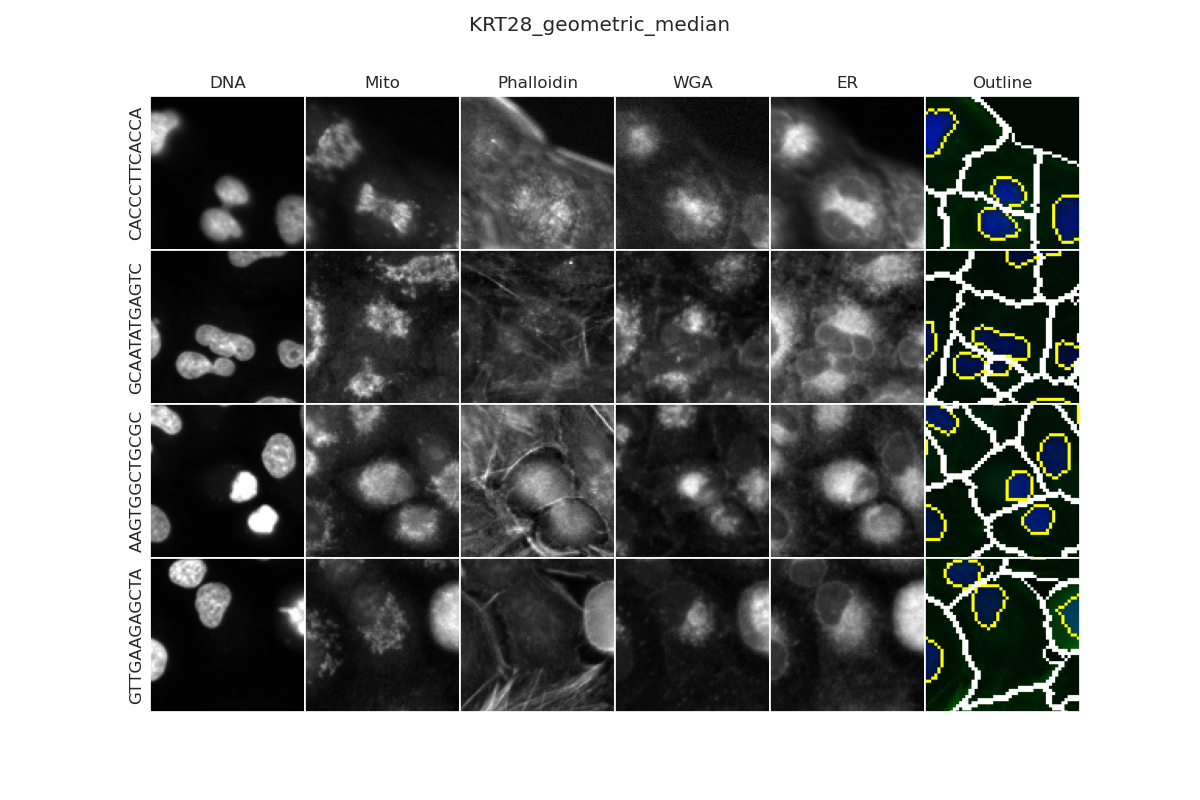

KRT28_geometric_median
CPU times: user 2min 32s, sys: 8.59 s, total: 2min 41s
Wall time: 3min 2s


In [5]:
%%time

input_gene_or_guide='KRT28'
# input_gene_or_guide='GTTGAAGAGCTAGATCAACG'

########################## set directories
batch='20200805_A549_WG_Screen';
rootDir='/home/ubuntu/calbucket/projects/2018_11_20_Periscope_Calico/'
sc_files_dir=rootDir+'workspace/software/CP186-A549-WG/data/1.profiles/20200805_A549_WG_Screen/single_cell/\
single_cell_by_guide/'

im_size=5500 # hardcoded for now, TODO: create a dictionary if this number is different for 257
#################### options for parameters to set
n_cells=6
box_size=100

# how we select cells which can be 'random','representative','geometric_median'
cell_selection_method='geometric_median'

channels=['DNA','Mito','Phalloidin','WGA','ER','Outline']

##################### read metadata and create the file name for input guide or gene
metadata_dir=rootDir+'workspace/metadata/'+batch+'/'
metadata_orig= pd.read_csv(metadata_dir+'Barcodes.csv')

input_matched_rows = metadata_orig[(metadata_orig['gene_symbol']==input_gene_or_guide) | (metadata_orig['sgRNA']==input_gene_or_guide)]
gene=input_matched_rows.gene_symbol.unique().tolist()[0]
guides_ls=input_matched_rows.sgRNA.unique().tolist()

all_guides_gms_ls=[]
# gene_guids_ls=glob.glob(sc_files_dir+'*_'+input_gene+'.csv.gz')
gene_guids_ls=[sc_files_dir+batch+'_single_cell_normalized_ALLBATCHES__'+gi+'_'+gene+'.csv.gz' for gi in guides_ls]

for gi in gene_guids_ls:
    df_p_s=pd.read_csv(gi);

    for ch in channels:
        df_p_s["PathName_Corr"+ch]=rootDir+batch+'/images_corrected_cropped/'+df_p_s["Metadata_Foci_plate"]+'_'+df_p_s["Metadata_Foci_well"]+'/Corr'+ch
        df_p_s["FileName_Corr"+ch]="Corr"+ch+"_"+"Site_"+df_p_s["Metadata_Foci_site_location"].astype(str)+".tiff"

    df_p_s["Path_Outlines"]=rootDir+'workspace/analysis/'+batch+'/'+df_p_s["Metadata_Foci_plate"]+'-'+df_p_s["Metadata_Foci_well"]+'-'+df_p_s["Metadata_Foci_site_location"].astype(str)+'/'\
    +'/CorrDNA_Site_'+df_p_s["Metadata_Foci_site_location"].astype(str)+'_Overlay.png'

    df_p_s["Nuclei_Location_Center_X"]=df_p_s["Cells_AreaShape_Center_X"];
    df_p_s["Nuclei_Location_Center_Y"]=df_p_s["Cells_AreaShape_Center_Y"];

    df_p_s=edgeCellFilter2(df_p_s,im_size,box_size/2);

    if df_p_s.shape[0]>0:
        df_samples,cp_features_analysis = extract_single_cell_samples(df_p_s.sample(n = np.min([1500,df_p_s.shape[0]]),\
                        replace = False).reset_index(drop=True),n_cells,cell_selection_method);
        all_guides_gms_ls.append(df_samples)

df_p_s_all=pd.concat(all_guides_gms_ls,ignore_index=True).drop_duplicates(ignore_index=True)    

if len(gene_guids_ls)>1 and df_p_s_all.shape[0]>n_cells:
    df_samples=df_p_s_all.sample(n = np.min([n_cells,df_p_s_all.shape[0]]),replace = False).reset_index(drop=True)
    
else:
    df_samples=df_p_s_all.copy()

################  visualize cells

f=visualize_n_SingleCell_pooled(channels,df_samples,box_size,im_size,title=input_gene_or_guide+'_'+cell_selection_method);

In [4]:
# df_samples
# f=visualize_n_SingleCell_pooled(channels,df_samples,box_size,im_size,title=input_gene_or_guide+'_'+cell_selection_method);

In [62]:
# visualize_n_SingleCell_pooled(channels,df_samples,box_size,im_size,title=cell_selection_method);
# df_samples
# df_p_s

In [63]:
def pooled_cell_painting_single_cell_visualization(input_gene_or_guide,batch,rootDir,\
            n_cells=6,box_size=100,channels=['DNA','Mito','Phalloidin','WGA','ER','Outline'],\
                                                   cell_selection_method='random'):
    

    ########################## set directories
#     batch='20200805_A549_WG_Screen';
#     rootDir='/home/ubuntu/calbucket/projects/2018_11_20_Periscope_Calico/'
    sc_files_dir=rootDir+'workspace/software/CP186-A549-WG/data/1.profiles/20200805_A549_WG_Screen/single_cell/single_cell_by_guide/'

    im_size=5500 # hardcoded for now, TODO: create a dictionary if this number is different for 257

    ##################### read metadata and create the file name for input guide or gene
    metadata_dir=rootDir+'workspace/metadata/'+batch+'/'
    metadata_orig= pd.read_csv(metadata_dir+'Barcodes.csv')

    input_matched_rows = metadata_orig[(metadata_orig['gene_symbol']==input_gene_or_guide) | (metadata_orig['sgRNA']==input_gene_or_guide)]
    gene=input_matched_rows.gene_symbol.unique().tolist()[0]
    guides_ls=input_matched_rows.sgRNA.unique().tolist()

    all_guides_gms_ls=[]
    # gene_guids_ls=glob.glob(sc_files_dir+'*_'+input_gene+'.csv.gz')
    gene_guids_ls=[sc_files_dir+batch+'_single_cell_normalized_ALLBATCHES__'+gi+'_'+gene+'.csv.gz' for gi in guides_ls]

    for gi in gene_guids_ls:
        df_p_s=pd.read_csv(gi);

        for ch in channels:
            df_p_s["PathName_Corr"+ch]=rootDir+batch+'/images_corrected_cropped/'+df_p_s["Metadata_Foci_plate"]+'_'+df_p_s["Metadata_Foci_well"]+'/Corr'+ch
            df_p_s["FileName_Corr"+ch]="Corr"+ch+"_"+"Site_"+df_p_s["Metadata_Foci_site_location"].astype(str)+".tiff"

        df_p_s["Path_Outlines"]=rootDir+'workspace/analysis/'+batch+'/'+df_p_s["Metadata_Foci_plate"]+'-'+df_p_s["Metadata_Foci_well"]+'-'+df_p_s["Metadata_Foci_site_location"].astype(str)+'/'\
        +'/CorrDNA_Site_'+df_p_s["Metadata_Foci_site_location"].astype(str)+'_Overlay.png'

        df_p_s["Nuclei_Location_Center_X"]=df_p_s["Cells_AreaShape_Center_X"];
        df_p_s["Nuclei_Location_Center_Y"]=df_p_s["Cells_AreaShape_Center_Y"];

        df_p_s=edgeCellFilter2(df_p_s,im_size,box_size/2);

        if df_p_s.shape[0]>0:
            df_samples,cp_features_analysis = extract_single_cell_samples(df_p_s.sample(n = np.min([1500,df_p_s.shape[0]]),\
                            replace = False).reset_index(drop=True),n_cells,cell_selection_method);
            all_guides_gms_ls.append(df_samples)

    df_p_s_all=pd.concat(all_guides_gms_ls,ignore_index=True).drop_duplicates(ignore_index=True)    

    if len(gene_guids_ls)>1 and df_p_s_all.shape[0]>n_cells:
        df_samples=df_p_s_all.sample(n = np.min([n_cells,df_p_s_all.shape[0]]),replace = False).reset_index(drop=True)

    else:
        df_samples=df_p_s_all.copy()

    ################  visualize cells

    return visualize_n_SingleCell_pooled(channels,df_samples,box_size,im_size,title=input_gene_or_guide+'_'+cell_selection_method);


input_gene_or_guide='KRT28'
# input_gene_or_guide='GTTGAAGAGCTAGATCAACG'

batch='20200805_A549_WG_Screen';
rootDir='/home/ubuntu/calbucket/projects/2018_11_20_Periscope_Calico/'


pooled_cell_painting_single_cell_visualization(input_gene_or_guide,batch,rootDir);

In [43]:
# metadaDataFiles
# metadata_orig
# df_p_s.columns
# df_p_s[df_p_s.eq(5500).any(1)]

In [23]:
# os.listdir("/home/ubuntu/calbucket/projects/2018_11_20_Periscope_Calico/workspace/software/CP257-HeLa-WG/data/1.profiles/20210422_6W_CP257/single_cell/")

In [7]:
# python restore_intelligent.py imaging-platform "projects/2015_10_05_DrugRepurposing_AravindSubramanian_GolubLab_Broad/workspace/backend/2016_04_01_a549_48hr_batch1/SQ00015195/"

### Read single cell data per guide takes ~1 mins

In [4]:
%%time
file_name='/home/ubuntu/calbucket/projects/2018_11_20_Periscope_Calico/workspace/\
software/CP186-A549-WG/data/1.profiles/20200805_A549_WG_Screen/single_cell/\
single_cell_by_guide/20200805_A549_WG_Screen_single_cell_normalized_ALLBATCHES__GTTGAAGAGCTAGATCAACG_KRT28.csv.gz'
df_p_s0=pd.read_csv(file_name);
df_p_s0.head()

CPU times: user 1min 5s, sys: 2.11 s, total: 1min 7s
Wall time: 1min 23s


,Metadata_Foci_Parent_Cells,Metadata_Foci_Cell_Quality_Index,Metadata_Foci_Barcode_MatchedTo_GeneCode,Metadata_Foci_Barcode_MatchedTo_Barcode,Metadata_Foci_Barcode_MatchedTo_Score_mean,Metadata_Foci_Barcode_MatchedTo_Score_count,Metadata_Foci_cell_quality_method,Metadata_Foci_ImageNumber,Metadata_Foci_site,Metadata_Foci_plate,...,Align_Xshift_WGA,Align_Yshift_AlignedRed,Align_Yshift_ConA,Align_Yshift_DAPI_Painting,Align_Yshift_Mito,Align_Yshift_Phalloidin,Align_Yshift_WGA,Metadata_site,Cells_AreaShape_Center_X,Cells_AreaShape_Center_Y
0,93,2,KRT28,GTTGAAGAGCTAGATCAACG,0.83333,1,simple,441,CP186A-Well3-75,CP186A,...,-7.0,0.0,56.0,56.0,56.0,56.0,56.0,CP186A-Well3-75,5126.00,84.667
1,198,2,KRT28,GTTGAAGAGCTAGATCAACG,0.83333,2,simple,441,CP186A-Well3-75,CP186A,...,-7.0,0.0,56.0,56.0,56.0,56.0,56.0,CP186A-Well3-75,672.33,129.980
2,1428,2,KRT28,GTTGAAGAGCTAGATCAACG,0.83333,1,simple,441,CP186A-Well3-75,CP186A,...,-7.0,0.0,56.0,56.0,56.0,56.0,56.0,CP186A-Well3-75,2576.20,1012.900
3,1584,2,KRT28,GTTGAAGAGCTAGATCAACG,0.83333,2,simple,441,CP186A-Well3-75,CP186A,...,-7.0,0.0,56.0,56.0,56.0,56.0,56.0,CP186A-Well3-75,2423.60,1101.000
4,1586,2,KRT28,GTTGAAGAGCTAGATCAACG,0.83333,9,simple,441,CP186A-Well3-75,CP186A,...,-7.0,0.0,56.0,56.0,56.0,56.0,56.0,CP186A-Well3-75,2600.80,1115.700


In [13]:
# df_p_s0[df_p_s0.columns[df_p_s0.columns.str.contains('utline')]]
df_p_s0.columns[df_p_s0.columns.str.contains('uid')]

Index([], dtype='object')

In [8]:
# df_p_s0['Cells_AreaShape_Center_X'].describe()

In [13]:
# visualize_n_SingleCell_pooled(channels,df_samples,box_size,im_size,title=cell_selection_method);

### Unarchive needed data

In [ ]:
# def unarchive_file(f2unarchive,bucket_name,user_profile):
#     """
#     unarchive input file

#     Inputs:
#     bucket_name: eg, pooled-cell-painting, imaging-plateform
#     user_profile: profile name that is used for accessing the above bucket (check in sudo vim ~/.aws/credentials)
#     proj_path: path to the project eg,2018_11_20_Periscope_Calico/workspace/analysis/

#     output:
#     command to run
#     """

#     cmd='aws s3api  restore-object  --profile '+user_profile+\
#             ' --bucket '+bucket_name+'  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/'+f2unarchive+'   --restore-request GlacierJobParameters={"Tier"="Standard"}'
#     return cmd

user_profile='calico'
bucket_name='pooled-cell-painting'

# for p in plates:
#     for w in wells:
#         for s in sites:
# plate_well_dirs_ls=os.listdir(rootDir+'/workspace/analysis/'+batch)
for di in plate_well_dirs_ls:
    f2unarchive='workspace/analysis/'+batch+'/'+di+'/CorrDNA_Site_'+di.split('-')[-1]+'_Overlay.png'
    if os.path.exists(rootDir+f2unarchive):
        cmd='aws s3api  restore-object  --profile '+user_profile+\
        ' --bucket '+bucket_name+'  --key projects/2018_11_20_Periscope_Calico/'+\
        f2unarchive+'   --restore-request GlacierJobParameters={"Tier"="Standard"}'
        print(cmd)
        os.system(cmd)

In [46]:
plate_well_dirs_ls[0].split('-')[-1]

'1'

## Plot geometric median of all guides of an input gene

In [ ]:
import glob
rootDir='/home/ubuntu/calbucket/projects/2018_11_20_Periscope_Calico/'
sc_files_dir=rootDir+'workspace/software/CP186-A549-WG/data/1.profiles/20200805_A549_WG_Screen/single_cell/\
single_cell_by_guide/'
batch='20200805_A549_WG_Screen';

### metadata 
metadata_dir=rootDir+'workspace/metadata/'+batch+'/'
metadaDataFiles=os.listdir(metadata_dir)
metadata_orig= pd.read_csv(metadata_dir+metadaDataFiles[0])

# input_gene='KRT28'
box_size=100
im_size=5500
n_cells=0
cell_selection_method='geometric_median'
channels=['DNA','Mito','Phalloidin','WGA','ER','Outline']

genes_ls=metadata_orig.gene_symbol.unique().tolist()

for igi in range(1224,len(genes_ls)):
    input_gene=genes_ls[igi]
    all_guides_gms_ls=[]
    gene_guids_ls=glob.glob(sc_files_dir+'*_'+input_gene+'.csv.gz')
    for gi in gene_guids_ls:
        df_p_s=pd.read_csv(gi);
        
        for ch in channels:
            df_p_s["PathName_Corr"+ch]=rootDir+batch+'/images_corrected_cropped/'+df_p_s["Metadata_Foci_plate"]+'_'+df_p_s["Metadata_Foci_well"]+'/Corr'+ch
            df_p_s["FileName_Corr"+ch]="Corr"+ch+"_"+"Site_"+df_p_s["Metadata_Foci_site_location"].astype(str)+".tiff"

        df_p_s["Path_Outlines"]=rootDir+'workspace/analysis/'+batch+'/'+df_p_s["Metadata_Foci_plate"]+'-'+df_p_s["Metadata_Foci_well"]+'-'+df_p_s["Metadata_Foci_site_location"].astype(str)+'/'\
        +'/CorrDNA_Site_'+df_p_s["Metadata_Foci_site_location"].astype(str)+'_Overlay.png'

        df_p_s["Nuclei_Location_Center_X"]=df_p_s["Cells_AreaShape_Center_X"];
        df_p_s["Nuclei_Location_Center_Y"]=df_p_s["Cells_AreaShape_Center_Y"];
        
        df_p_s=edgeCellFilter2(df_p_s,im_size,box_size/2);

        if df_p_s.shape[0]>0:
            df_samples,cp_features_analysis = extract_single_cell_samples(df_p_s.sample(n = np.min([1500,df_p_s.shape[0]]),\
                            replace = False).reset_index(drop=True),n_cells,cell_selection_method);
            all_guides_gms_ls.append(df_samples)

    all_guides_gms_df=pd.concat(all_guides_gms_ls,ignore_index=True).drop_duplicates(ignore_index=True)
    
    if all_guides_gms_df.shape[0]==1:
        all_guides_gms_df=pd.concat([all_guides_gms_df]*2, ignore_index=True)    
    
    fig=visualize_n_SingleCell_pooled(channels,all_guides_gms_df,box_size,im_size,title=input_gene+'_'+cell_selection_method);

    
    resultsDir='/home/ubuntu/bucket/projects/2018_11_20_Periscope_Calico/workspace/visualizations/20200805_A549_WG_Screen/geometric_median_guide_level/'
    fig.savefig(resultsDir+input_gene+'.png')  
    plt.ioff()

In [41]:
df_p_s=pd.read_csv(gi);
df_p_s["Nuclei_Location_Center_X"]=df_p_s["Cells_AreaShape_Center_X"];
df_p_s["Nuclei_Location_Center_Y"]=df_p_s["Cells_AreaShape_Center_Y"];
df_p_s=edgeCellFilter2(df_p_s,im_size,box_size/2);
# df_p_s.shape

In [12]:
# genes_ls.index('LOC653602')
# pd.concat([all_guides_gms_df]*2, ignore_index=True)
len(genes_ls)

20393

In [7]:
igi,all_guides_gms_df.shape,gene_guids_ls

(101,
 (1, 3794),
 ['/home/ubuntu/calbucket/projects/2018_11_20_Periscope_Calico/workspace/software/CP186-A549-WG/data/1.profiles/20200805_A549_WG_Screen/single_cell/single_cell_by_guide/20200805_A549_WG_Screen_single_cell_normalized_ALLBATCHES__TTCATGGCTCCAGGCATCAG_DEFB107B.csv.gz'])

In [27]:
os.system('mkdir -p /home/ubuntu/bucket/projects/2018_11_20_Periscope_Calico/workspace/visualizations/20200805_A549_WG_Screen/geometric_median_guide_level')

0

In [29]:
ls /home/ubuntu/bucket/projects/2018_11_20_Periscope_Calico/workspace/visualizations

20200805_A549_WG_Screen/


In [ ]:
# metadata_orig.gene_symbol.unique().tolist()